
* Due to my last file being wiped form some sort of mistake, I'm going be breezing though till the point of my last entry.
I'll try to come back later to fill out such sections if I'm to have time later this week.
** Importing packages & data; exploring & splitting; and one-hot encoding for independent categorication.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical                                
from tensorflow.keras.models import Sequential, load_model                       
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout   

data = []
labels = []
current_path = os.getcwd()
train_path = os.path.join(current_path, 'train')

class_folders = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
class_folders.sort(key=int)  # Sort numerically

for class_num in class_folders:
    path = os.path.join(train_path, class_num)
    images = os.listdir(path)
    print(f"Loading class {class_num}: {len(images)} images")
    
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(int(class_num))
        except Exception as e:
            print(f"Error loading image {a}: {e}")
            
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.20, random_state=42
)

base_dir = "/home/nate/NextCloud/Roam/Classes/Intro_to_ML/assignmnets/week_15/"
csv_path = os.path.join(base_dir, "Test.csv")

y_test_df = pd.read_csv(csv_path)
y_test = y_test_df["ClassId"].values
imgs = y_test_df["Path"].values # This contains values like "Test/00000.png"

data = []
for img_relative_path in imgs: # Renamed 'img' to be more descriptive
    
    # *** THIS IS THE CRITICAL FIX: Construct the full path ***
    img_full_path = os.path.join(base_dir, img_relative_path)

    try:
        # Use the newly constructed full path
        image = Image.open(img_full_path) 
        image = image.resize((30,30))
        data.append(np.array(image))
    except Exception as e:
        # Print the problematic full path for better debugging
        print(f"Error loading {img_full_path}: {e}")
        
X_test = np.array(data)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

num_classes = 43


y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


print(f"\nX_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

2025-12-07 21:15:48.726076: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 21:15:48.776887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 21:15:50.286471: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Loading class 4: 1980 images
Loading class 5: 1860 images
Loading class 6: 420 images
Loading class 7: 1440 images
Loading class 8: 1410 images
Loading class 9: 1470 images
Loading class 32: 1 images
Loading class 33: 175 images
Loading class 34: 420 images
Loading class 35: 1200 images
Loading class 36: 390 images
Loading class 37: 210 images
Loading class 38: 2070 images
Loading class 39: 300 images
Loading class 40: 360 images
Loading class 41: 240 images
Loading class 42: 240 images
(14186, 30, 30, 3) (14186,)

X_train: (11348, 30, 30, 3), X_val: (2838, 30, 30, 3), X_test: (12630, 30, 30, 3)
y_train: (11348, 43), y_val: (2838, 43), y_test: (12630, 43)


Just to make a note here as I remember I didn't yet get to implementing One-hot-encoding, I had used the Keras method for implmenting this encoding method and had used such a method on the 'labels' array I had created this eailer. This was done to ensure that labels, represented as numerical values, can be caterogically assigned wihtout having any issue of supposed ranking by the model. 

I had to re-write the way in which the folder for the images would be searched due to the as the orginal would assume and search fot a object ( here a dir ) to be termed zero.

Later on I had to re-write this again so as to properly pre-load the alternative dataset for the test sets used against the validated model.
** Modeling.
What follows next is the creation of the nerual network by creating a sequential network of three convolution layers along with augmentations to the layers by MaxPool2D and Dropout; towards the end, flatting will take place so as the produce a two dimensional output for proper classification.

In [4]:
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)), 
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax') 
])

So with the first layer created, it becomes the question If I simply add three more of that type or if there is a change due to the input convolution layer only need for the input images. Looking into it, I find that the only thing that needs to be changed is with repsect to the convolution within the first layer where the input_shape is removed as the input to the next layer isn't in the form of images (that'd be created later)

Another thing I'd like to note here is the doubling factor I had used for the amount of filters I'd like the model to use for increasing the depth of features to learn from.

What is dense here and why does it seem to have a simler parameters as Conv2D? Should the number of whatever it is be set to a higher amount? Looking into this as well, the Dense layer is..well it's that: it's a dense network of neurons, but it does service a specific purpose here. Each neuron in this layer is connected to the previous layer, where the weights in the dense network is gotten from the weighted sum of all inputs from the previous layer, which after this such a sum is passed to an activation function like relu or sigmoid here. The difference in activation functions actually help to understand the purpose behind each dense network; the former is the dense network for extracting global patterns of liner combinations of patterns that he model has learned where as the latter is for classifying such extracted features as this or that.   

*** Compiling the model and Running the Model.
This will not only crete the model but also pass various parameteres to the function in order for the model to adhere to.

In [8]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(X_train, y_train, batch_size=32, epochs=30)

Epoch 1/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9722 - loss: 0.0955
Epoch 2/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9712 - loss: 0.0980
Epoch 3/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9755 - loss: 0.0887
Epoch 4/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9780 - loss: 0.0809
Epoch 5/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9767 - loss: 0.0774
Epoch 6/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9801 - loss: 0.0710
Epoch 7/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9827 - loss: 0.0648
Epoch 8/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9818 - loss: 0.0610
Epoch 9/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9818 - loss: 0.0611
Epoch 10/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9845 - loss: 0.0560
Epoch 11/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9864 - loss: 0.0520
Epoch 12/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 

Due to low compute I had chosen Adam for the optimizer; I also choose to use EarlyStopping via callback to have some on-the-fly vaildition to find where the sweet spot is for number of epochs.

**** Validation-trained Accuracy.

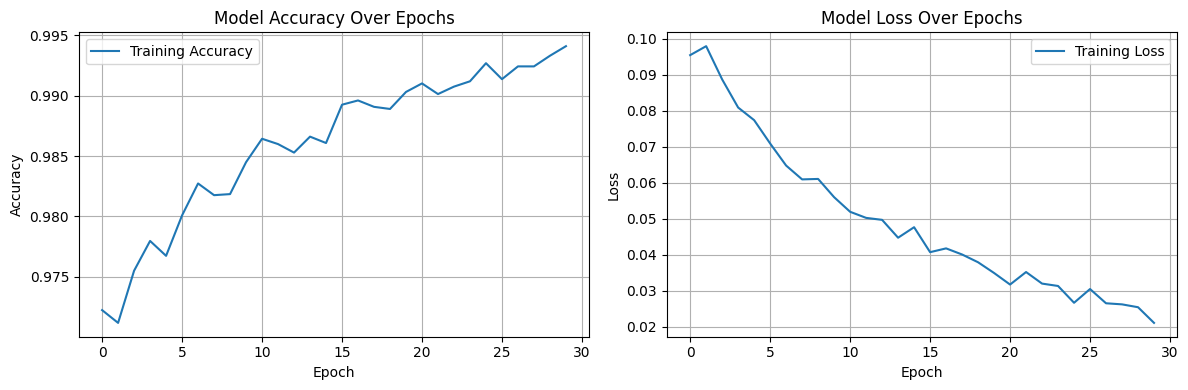

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)


axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


**** Getting predictions

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00       720
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.33      0.95      0.50       660
           5       0.15      0.98      0.27       630
           6       0.59      0.74      0.66       150
           7       0.71      0.90      0.79       450
           8       0.58      0.97      0.73       450
           9       0.19      1.00      0.32       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16    

/home/nate/venvs/rl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nate/venvs/rl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nate/venvs/rl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


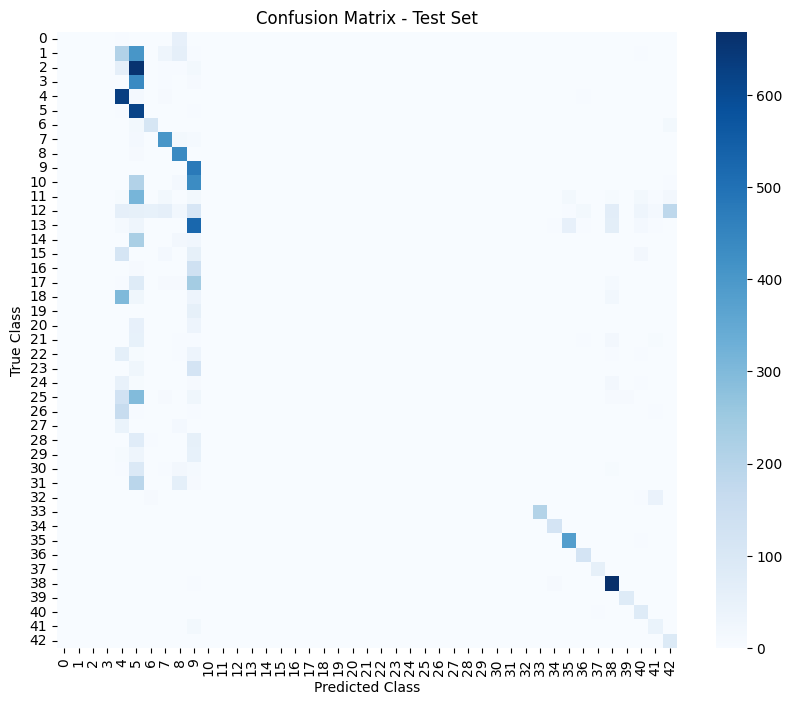

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1) 

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

** Deployment and Review
Depoloyment would be in some sort of pipeline, but to review what the confusion matrix tells me when predicting from the test set is to see that the set it's been trained on might have been class imbalanced; but for what it was trained on, it was highly accurate in classifying those specific traffic signs.

To fix the class imbalance and gain a futher generalization of traffic signs either class weighting or simply getting the proper data would need to be done.